In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [3]:
scan = set(['ipsweep', 'portsweep', 'nmap', 'satan'])
dos = set(['neptune', 'smurf', 'pod', 'teardrop', 'land'])
access = set(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezclient', 'warezmaster'])
exploit = set(['buffer_overflow', 'loadmodule', 'rootkit', 'perl'])
backdoor = set(['back','spy'])

df['attack_category'] = None

for i in range(len(df)):
  attk = df.loc[i,'attack']
  if attk in scan:
    df.loc[i,'attack_category'] = 'scan'
  elif attk in dos:
    df.loc[i,'attack_category'] = 'dos'
  elif attk in access:
    df.loc[i,'attack_category'] = 'access'
  elif attk in exploit:
    df.loc[i,'attack_category'] = 'exploit'
  elif attk in backdoor:
    df.loc[i,'attack_category'] = 'backdoor'
  else:
    df.loc[i,'attack_category'] = 'normal'

In [44]:
X = df.drop(['attack','is_attack'],axis=1)
y = df['is_attack']

In [59]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=df['attack_category'],random_state=42)

In [60]:
X_train['attack_category'].value_counts()

attack_category
normal      53874
dos         35977
scan         9325
access        794
backdoor      766
exploit        42
Name: count, dtype: int64

In [61]:
X_test['attack_category'].value_counts()

attack_category
normal      13469
dos          8994
scan         2331
access        199
backdoor      192
exploit        10
Name: count, dtype: int64

In [58]:
X_train.shape

(88181, 43)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [7]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [8]:
from sklearn.ensemble  import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [28]:
y_pred = rf.predict(X_test)

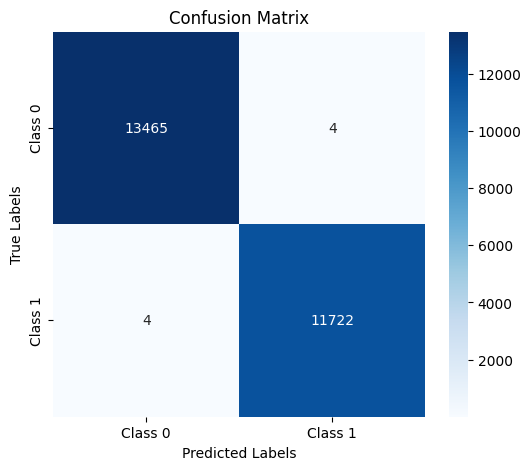

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=['normal','attack']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13469
      attack       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [31]:
y_pred_df = pd.DataFrame(y_pred,index=y_test.index)
y_pred_df.isna().sum()

0    0
dtype: int64

In [32]:
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]

In [33]:
combined_pred.shape

(25195, 3)

In [35]:
combined_pred = combined_pred[np.logical_or(combined_pred['is_attack'] == combined_pred['is_attack_pred'],combined_pred['predict_prob'] > 0.90)]

In [36]:
combined_pred.shape

(25187, 3)

In [37]:
op = pd.merge(X_test,combined_pred,left_index=True,right_index=True)
op = pd.merge(op,df['attack_category'],left_index=True,right_index=True)
op.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,is_attack,is_attack_pred,predict_prob,attack_category
68092,-0.110691,0,14,9,-0.008280,-0.005358,-0.013732,-0.089571,-0.007225,-0.095142,...,4.257069,-0.638192,-0.623099,-0.388564,-0.376713,-1.090896,1,1,1.0,scan
31946,-0.110691,1,54,9,-0.008057,-0.005284,-0.013732,-0.089571,-0.007225,-0.095142,...,-0.288957,-0.638192,-0.623099,-0.388564,-0.376713,0.652918,0,0,0.0,normal
35617,-0.110691,1,69,5,-0.008281,-0.005358,-0.013732,-0.089571,-0.007225,-0.095142,...,-0.288957,1.613063,1.623815,-0.388564,-0.376713,-0.654942,1,1,1.0,dos
56323,-0.110691,1,26,5,-0.008281,-0.005358,-0.013732,-0.089571,-0.007225,-0.095142,...,-0.288957,1.613063,1.623815,-0.388564,-0.376713,-0.218989,1,1,1.0,dos
94285,-0.110691,1,24,9,-0.008254,-0.003940,-0.013732,-0.089571,-0.007225,-0.095142,...,0.424145,-0.638192,-0.623099,-0.388564,-0.376713,0.652918,0,0,0.0,normal


In [38]:
attacks = op[op['is_attack_pred'] == 1].copy()
X1 = attacks.drop(['is_attack','is_attack_pred','attack_category','predict_prob'],axis=1)
y1 = attacks['attack_category']

In [39]:
attacks['attack_category'].value_counts()

attack_category
dos         8994
scan        2329
access       199
backdoor     191
exploit        9
Name: count, dtype: int64

In [40]:
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y1)

In [41]:
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y_encoded,test_size=0.2,stratify=y_encoded,random_state=42)

In [42]:
from collections import Counter
Counter(y1_train)

Counter({np.int64(2): 7195,
         np.int64(4): 1863,
         np.int64(0): 159,
         np.int64(1): 153,
         np.int64(3): 7})

In [43]:
from collections import Counter
Counter(y1_test)

Counter({np.int64(2): 1799,
         np.int64(4): 466,
         np.int64(0): 40,
         np.int64(1): 38,
         np.int64(3): 2})

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=3)
X_train_smt, y_train_smt = smote.fit_resample(X1_train, y1_train) #_encoded

In [25]:
y1.value_counts()

attack_category
dos         8954
scan        2363
access       199
backdoor     195
exploit        8
Name: count, dtype: int64

In [26]:
from collections import Counter
Counter(y_train_smt)

Counter({np.int64(2): 7163,
         np.int64(4): 7163,
         np.int64(0): 7163,
         np.int64(1): 7163,
         np.int64(3): 7163})

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model2 = LogisticRegression(max_iter=5000)
model2.fit(X_train_smt, y_train_smt)

LogisticRegression(max_iter=5000)

In [28]:
y1_pred = model2.predict(X1_test)

In [29]:
accuracy = accuracy_score(y1_test, y1_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9962


In [31]:
name_labels = [target_encoder.classes_[i] for i in range(0,5)]

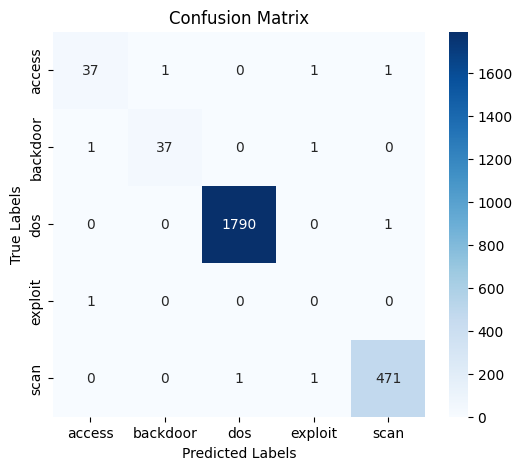

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y1_test, y1_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_labels, yticklabels=name_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y1_test,y1_pred,target_names=name_labels))

              precision    recall  f1-score   support

      access       0.95      0.93      0.94        40
    backdoor       0.97      0.95      0.96        39
         dos       1.00      1.00      1.00      1791
     exploit       0.00      0.00      0.00         1
        scan       1.00      1.00      1.00       473

    accuracy                           1.00      2344
   macro avg       0.78      0.77      0.78      2344
weighted avg       1.00      1.00      1.00      2344

